In [33]:
import logging
import os
import re
from typing import List
from typing import Union

import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path

In [34]:
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s',
                    level=logging.DEBUG)

In [35]:
def remove_non_numeric_data(df: pd.DataFrame) -> pd.DataFrame:
    """Removes non-numeric columns from a DataFrame (except for the first column)."""
    numeric_cols = df.select_dtypes(
        include=['number']).columns
    non_numeric_cols = df.columns.difference(
        numeric_cols)
    return df.drop(non_numeric_cols[1:], axis=1)


def filter_by_years(df: pd.DataFrame,
                    years_to_analyze: List[int]) -> pd.DataFrame:
    """Filters a DataFrame based on the specified years."""
    time_col = \
        df.filter(regex=r'.*Time.*|.*Obsdate*.|.*time-tag*.').columns[0]
    return df[df[time_col].dt.year.isin(years_to_analyze)]


def rename_time_columns_to_universal_format(df: pd.DataFrame) -> pd.DataFrame:
    """Renames time columns to a universal format (time0, time1, etc.)."""
    time_cols = df.filter(
        regex=r'.*Time.*|.*Obsdate*.|.*time-tag*.').columns
    df.columns = [f'time{i}' if col in time_cols else col for i, col in
                  enumerate(df.columns)]
    return df


def convert_to_universal_time_format(df: pd.DataFrame,
                                     time_period: str = 'M') -> pd.DataFrame:
    time_cols = df.select_dtypes(include='object').apply(
        pd.to_datetime, errors='coerce').dropna(
        how='all').columns

    df[time_cols] = df[time_cols].apply(pd.to_datetime,
                                        errors='coerce').apply(
        lambda s: s.dt.to_period(time_period))
    return df.groupby(time_cols[0]).median().reset_index()


def preprocess_solar_data(solar_data_file: Union[
    os.PathLike, str]) -> pd.DataFrame:
    """Preprocesses solar data by handling missing values and converting time formats."""
    df = pd.read_json(solar_data_file)
    df.dropna(inplace=True)
    df = convert_to_universal_time_format(df)
    return df


def preprocess_satellite_data(satellite_data_file: Union[os.PathLike, str],
                              years_to_analyze: List[int]) -> pd.DataFrame:
    """Preprocesses satellite data by removing non-numeric columns, converting time formats, and filtering by years."""
    df = pd.read_csv(satellite_data_file)
    df = remove_non_numeric_data(df)
    df = convert_to_universal_time_format(df)
    df = filter_by_years(df, years_to_analyze)
    return df


def merge_dataframes_by_time(df1: pd.DataFrame,
                             df2: pd.DataFrame) -> pd.DataFrame:
    """Merges two DataFrames based on their time columns."""
    df1 = rename_time_columns_to_universal_format(df1)
    df2 = rename_time_columns_to_universal_format(df2)
    return pd.merge(df1, df2, how='inner')


class SatelliteAnalyzer:
    def __init__(self, sat_name: str):
        self.sat_name = sat_name
        self.plot_sat_name = sat_name
        self.plot_desc_data_name = ""  # To be set later
        self.years_to_analyze: List[int] = [2023, 2022, 2021, 2020, 2019,
                                            2018, 2017, 2016, 2015,
                                            2014]

    def _plot_scatter_single_or_multiple(self, df: pd.DataFrame,
                                         x_cols: List[str],
                                         y_cols: List[str]) -> None:
        """Plots scatter plots for one or multiple y-columns against a single x-column."""
        markers = ['o', 's', '^', 'P', 'D', 'x', '+', 'v', '<', '>', '1', '2',
                   '3', '4']

        plt.figure(figsize=(10, 8))
        for i, y_col in enumerate(y_cols):
            for j, x_col in enumerate(x_cols):
                plt.scatter(df[x_col], df[y_col], label=x_col,
                            marker=markers[i + j])

        plt.title(
            f'{self.plot_sat_name}: {self.plot_desc_data_name}')

        plt.xlabel(f'{x_cols}')
        plt.ylabel(f'{y_cols}')

        plt.legend()
        plt.subplots_adjust(bottom=0.2)
        plt.show()

    def process(self, solar_data_file: Union[os.PathLike, str],
                satellite_data_file: Union[os.PathLike, str]) -> None:
        df_solar = preprocess_solar_data(solar_data_file)
        df_satellite = preprocess_satellite_data(satellite_data_file,
                                                 self.years_to_analyze)

        df_satellite = df_satellite.loc[:, df_satellite.nunique() > 1]

        # Select relevant columns (excluding time-related ones)
        solar_cols = df_solar.columns[~df_solar.columns.str.contains(
            r'.*Time.*|.*Obsdate*.|.*time-tag*.')]
        satellite_cols = df_satellite.columns[
            ~df_satellite.columns.str.contains(
                r'.*Time.*|.*Obsdate*.|.*time-tag*.')]

        df_merged = merge_dataframes_by_time(df_solar, df_satellite)
        self._plot_scatter_single_or_multiple(df_merged, solar_cols,
                                              satellite_cols)

    def start_analysis(self):
        data_dir: Path = Path("../data")
        solar_data_path: Path = data_dir / "observed_solar_cycle_indices.json"
        satellite_data_files: List[Path] = list(
            (data_dir / self.sat_name).glob("*.csv"))

        for sat_file in satellite_data_files:
            try:
                self.plot_desc_data_name = sat_file.stem
                self.process(solar_data_file=solar_data_path, satellite_data_file=sat_file)
            except Exception as ex:
                logging.exception(
                    f"Unexpected error processing file=[{sat_file}] : {ex}")
                pass

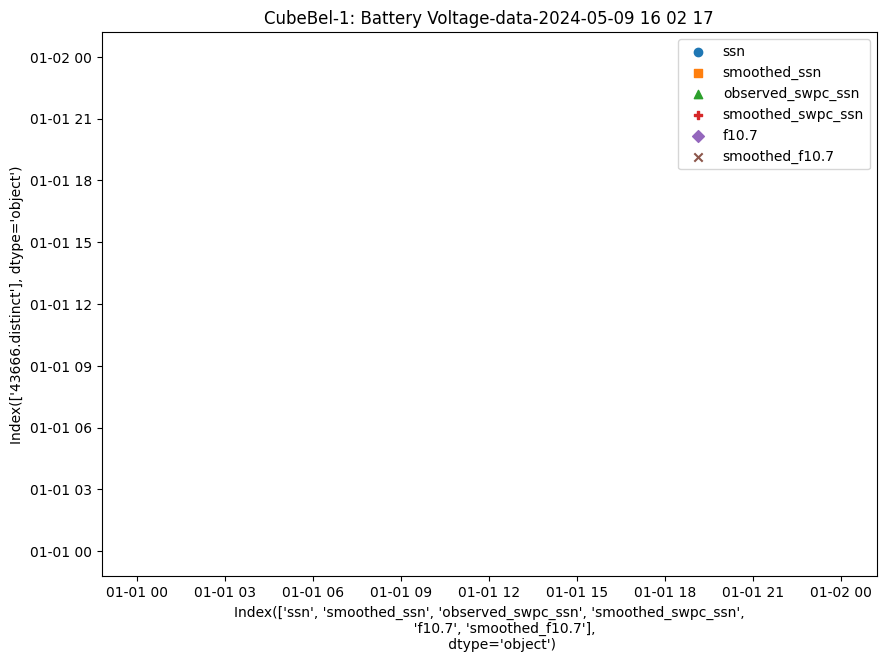

C:\Users\geugenm\AppData\Local\Temp\ipykernel_11120\659905006.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = df.apply(pd.to_datetime, errors='coerce')
2024-05-09 16:19:35,669 - ERROR - Unexpected error processing file=[..\data\CubeBel-1\merged_frames.csv] : index 0 is out of bounds for axis 0 with size 0
Traceback (most recent call last):
  File "C:\Users\geugenm\AppData\Local\Temp\ipykernel_11120\659905006.py", line 130, in start_analysis
    self.process(solar_data_file=solar_data_path, satellite_data_file=sat_file)
  File "C:\Users\geugenm\AppData\Local\Temp\ipykernel_11120\659905006.py", line 105, in process
    df_satellite = preprocess_satellite_data(satellite_data_file,
  File "C:\Users\geugenm\AppData\Local\Temp\ipykernel_11120\659905006.py", line 58, in preprocess_satellite_data
    df = filter_by_years(df, years_to_analyze)
  F

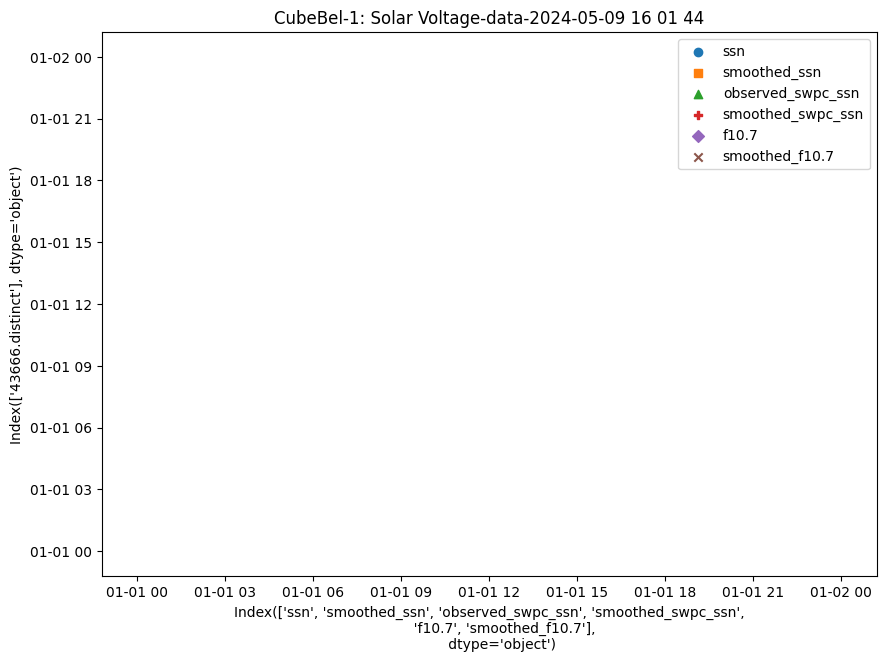

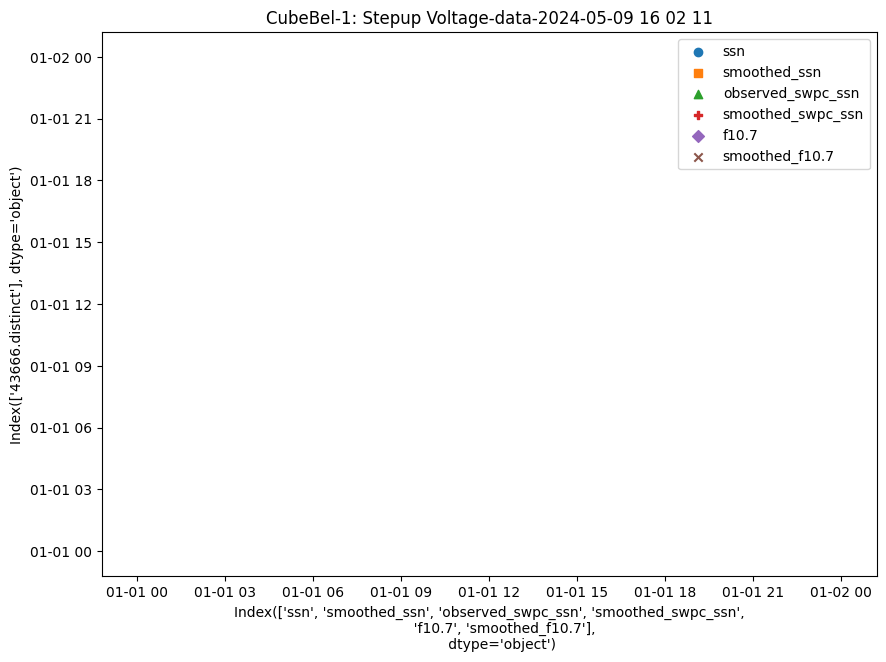

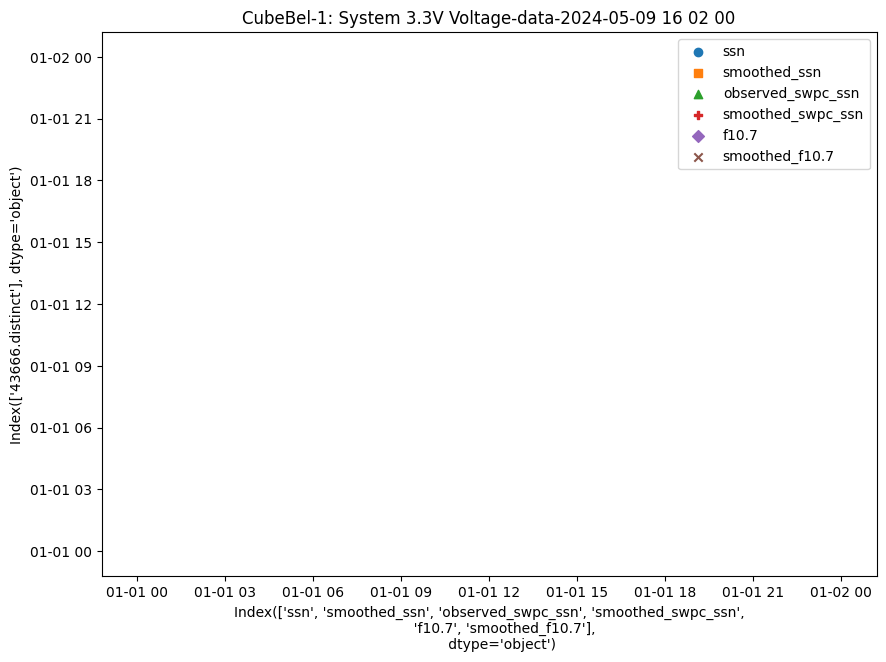

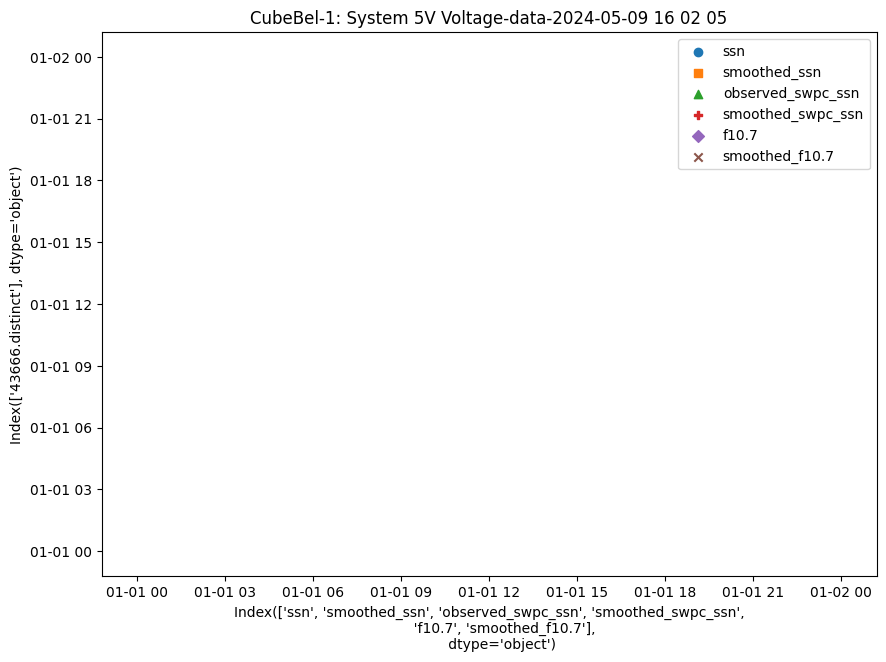

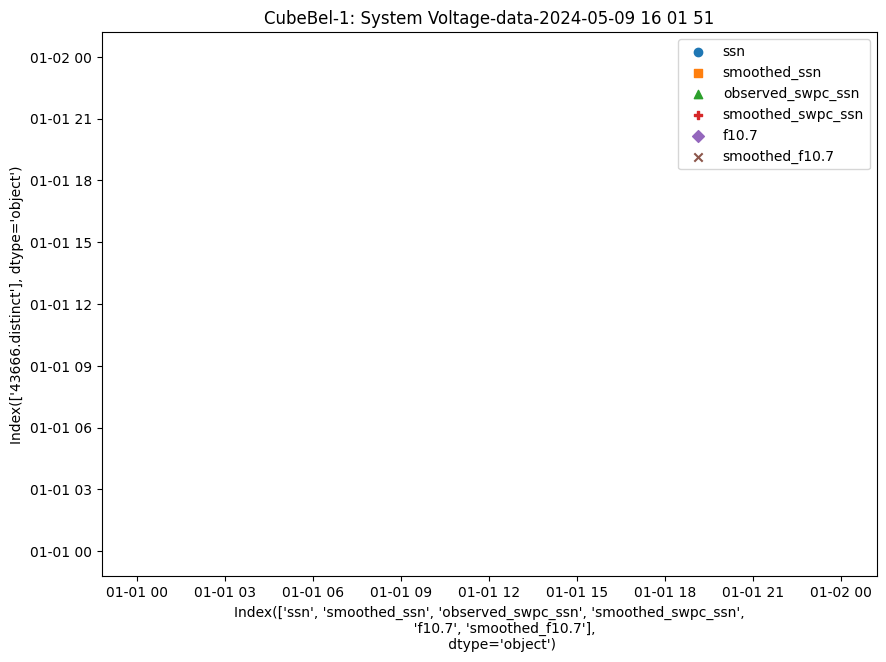

In [36]:
satellite_analyzer = SatelliteAnalyzer(sat_name="CubeBel-1")

satellite_analyzer.start_analysis() 